In [169]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor': '#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1.5',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12,
}
plt.rcParams.update(dark_style)
plt.rcParams['figure.figsize'] = (15, 10)
pd.options.display.float_format = '{:.2f}'.format

In [170]:
def transform_results(data):
    result_list = []
    for date, details in data.items():
        for auction, auction_data in details["auctions"].items():
            result_list.append({
                "Date": date,
                "Auction": auction,
                "CVaR": auction_data["cvar"] if "cvar" in auction_data else np.nan,
                "SMAPE (%)": auction_data["SMAPE"],
                "Net Volume": auction_data["net_volume_traded"],
                "Volume": auction_data["volume_traded"],
                "Profit": auction_data["profit"],
                "Forecasted Profit": auction_data["forecasted_profit"],
                "Profit Deviation": auction_data["profit"] - auction_data["forecasted_profit"],
            })
    results_df = pd.DataFrame(result_list)
    return results_df

In [171]:
def read_results(power, capacity, risk_averse_factor=None, model='deterministic'):
    if risk_averse_factor is not None:
        file = f'../Results/stochastic/battery_{power}MW_{capacity}MWh/run_results_l={risk_averse_factor}.json'
    elif model == 'deterministic':
        file = f'../Results/deterministic/battery_{power}MW_{capacity}MWh/run_results.json'
    elif model == 'robust':
        file = f'../Results/robust/battery_{power}MW_{capacity}MWh/run_results.json'
    else:
        raise ValueError('Invalid model')

    with open(file) as f:
        return json.load(f)

In [172]:
power = 10
capacity = 20
stochastic_l1 = transform_results(read_results(
    power, capacity, 1)['results'])
stochastic_l05 = transform_results(
    read_results(power, capacity, 0.5)['results'])
stochastic_l0 = transform_results(read_results(
    power, capacity, 0)['results'])

### Which strategy is more impacted by forecasting errors?


In [173]:
smape_table_data = {
    ('SMAPE (%)', ''): stochastic_l0.groupby('Auction')['SMAPE (%)'].mean(),
    ('Risk Averse Factor: 0', 'Volume'): stochastic_l0.groupby('Auction')['Volume'].mean(),
    ('Risk Averse Factor: 0', 'Profit Deviation'): stochastic_l0.groupby('Auction')['Profit Deviation'].mean(),
    ('Risk Averse Factor: 0.5', 'Volume'): stochastic_l05.groupby('Auction')['Volume'].mean(),
    ('Risk Averse Factor: 0.5', 'Profit Deviation'): stochastic_l05.groupby('Auction')['Profit Deviation'].mean(),
    ('Risk Averse Factor: 1', 'Volume'): stochastic_l1.groupby('Auction')['Volume'].mean(),
    ('Risk Averse Factor: 1', 'Profit Deviation'): stochastic_l1.groupby('Auction')['Profit Deviation'].mean(),
}
smape_table = pd.DataFrame(smape_table_data)
print(
    """
      1) This shows that a riskier trading strategy leads to higher deviations in realized profits from forecasted profits
         Probably because the riskier trading strategy is more aggressive and trades greater volumes.
    """
)
smape_table


      1) This shows that a riskier trading strategy leads to higher deviations in realized profits from forecasted profits
         Probably because the riskier trading strategy is more aggressive and trades greater volumes.
    


SMAPE (%) Risk Averse Factor: 0                   \
                                 Volume Profit Deviation   
Auction                                                    
DA          46.46                240.00         -2881.70   
IDA1        37.35                218.39          -835.77   
IDA2        35.97                 86.29          -180.36   

        Risk Averse Factor: 0.5                  Risk Averse Factor: 1  \
                         Volume Profit Deviation                Volume   
Auction                                                                  
DA                       235.64         -1695.26                233.29   
IDA1                     205.22          -260.39                206.44   
IDA2                      75.53          -295.57                 73.06   

                          
        Profit Deviation  
Auction                   
DA               -638.29  
IDA1             -525.27  
IDA2             -297.14


    This gives a visual and more clear picture of the deviations in realized profits from forecasted profits.
    


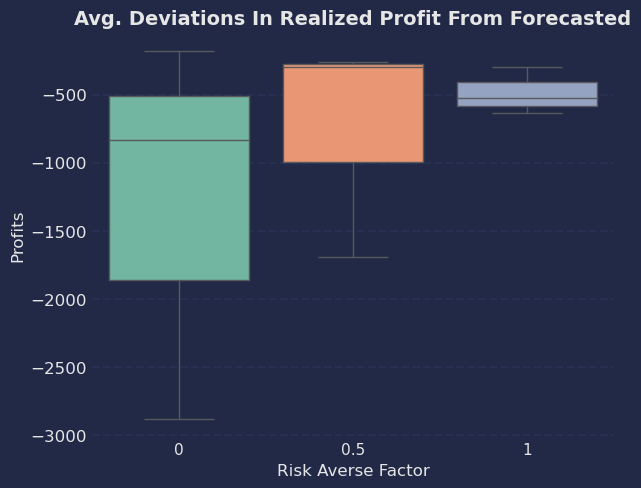

In [174]:
import seaborn as sns

combined = pd.DataFrame({
    "Profit Deviation (l=0)": stochastic_l0.groupby('Auction')['Profit Deviation'].mean(),
    "Profit Deviation (l=0.5)": stochastic_l05.groupby('Auction')['Profit Deviation'].mean(),
    "Profit Deviation (l=1)": stochastic_l1.groupby('Auction')['Profit Deviation'].mean(),
})

plt.figure(figsize=(6, 5))
sns.boxplot(data=combined, palette="Set2")
plt.title('Avg. Deviations In Realized Profit From Forecasted',
          fontsize=14, fontweight='bold')
plt.ylabel('Profits', fontsize=12)
plt.xlabel('Risk Averse Factor', fontsize=12)
plt.xticks([0, 1, 2], ['0', '0.5', '1'], fontsize=11)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
print(
    """
    This gives a visual and more clear picture of the deviations in realized profits from forecasted profits.
    """
)
plt.show()

### Does more risk mean more profit?


In [175]:
profit_table_data = {
    'Risk Averse Factor': [0, 0.5, 1],
    ('Profit', 'Mean'): [
        stochastic_l0.groupby('Date')['Profit'].sum().mean(),
        stochastic_l05.groupby('Date')['Profit'].sum().mean(),
        stochastic_l1.groupby('Date')['Profit'].sum().mean()
    ],
    ('Profit', 'Std'): [
        stochastic_l0.groupby('Date')['Profit'].sum().std(),
        stochastic_l05.groupby('Date')['Profit'].sum().std(),
        stochastic_l1.groupby('Date')['Profit'].sum().std()
    ]
}

profit_table = pd.DataFrame(profit_table_data)
profit_table.set_index('Risk Averse Factor', inplace=True)
profit_table.columns = pd.MultiIndex.from_tuples(
    [('Profit', 'Mean'), ('Profit', 'Std')]
)
print(
    """
    Lower risk means higher AND more stable profits.
    """
)
profit_table.sort_values(by=('Profit', 'Mean'), ascending=False)


    Lower risk means higher AND more stable profits.
    


Profit        
                      Mean     Std
Risk Averse Factor                
1.00               2321.90  965.32
0.50               2238.24 1051.07
0.00               1956.59 1346.53

In [176]:
profit_volume_table_data = {
    ('Risk Averse Factor: 0', 'Volume'): stochastic_l0.groupby('Auction')['Volume'].mean(),
    ('Risk Averse Factor: 0', 'Net Volume'): stochastic_l0.groupby('Auction')['Net Volume'].mean(),
    ('Risk Averse Factor: 0', 'Profit'): stochastic_l0.groupby('Auction')['Profit'].mean(),
    ('Risk Averse Factor: 0.5', 'Volume'): stochastic_l05.groupby('Auction')['Volume'].mean(),
    ('Risk Averse Factor: 0.5', 'Net Volume'): stochastic_l05.groupby('Auction')['Net Volume'].mean(),
    ('Risk Averse Factor: 0.5', 'Profit'): stochastic_l05.groupby('Auction')['Profit'].mean(),
    ('Risk Averse Factor: 1', 'Volume'): stochastic_l1.groupby('Auction')['Volume'].mean(),
    ('Risk Averse Factor: 1', 'Net Volume'): stochastic_l1.groupby('Auction')['Net Volume'].mean(),
    ('Risk Averse Factor: 1', 'Profit'): stochastic_l1.groupby('Auction')['Profit'].mean()
}
profit_volume_table = pd.DataFrame(profit_volume_table_data)
profit_volume_table.loc['Total'] = profit_volume_table.sum()
print("""
      1) Here we see that the less risky trading strategies make more profit on average while trading less volume.  
      2) Looking at the net volume traded, we see that the riskier strategy on average uses (relatively and absolutely) more volume for trading between auctions.
         The riskier strategies in this case sell greater volumes in the DA to later buy back in the IDAs than the l=1 strategy. 
      """)
profit_volume_table.style.map(
    lambda x: 'color: pink', subset=pd.IndexSlice['Total', :])


      1) Here we see that the less risky trading strategies make more profit on average while trading less volume.  
      2) Looking at the net volume traded, we see that the riskier strategy on average uses (relatively and absolutely) more volume for trading between auctions.
         The riskier strategies in this case sell greater volumes in the DA to later buy back in the IDAs than the l=1 strategy. 
      


In [177]:
profit_table_data = {
    ('Risk Averse Factor: 0', 'Profit', 'std'): stochastic_l0.groupby('Auction')['Profit'].std(),
    ('Risk Averse Factor: 0', 'Profit', 'mean'): stochastic_l0.groupby('Auction')['Profit'].mean(),
    ('Risk Averse Factor: 0.5', 'Profit', 'std'): stochastic_l05.groupby('Auction')['Profit'].std(),
    ('Risk Averse Factor: 0.5', 'Profit', 'mean'): stochastic_l05.groupby('Auction')['Profit'].mean(),
    ('Risk Averse Factor: 1', 'Profit', 'std'): stochastic_l1.groupby('Auction')['Profit'].std(),
    ('Risk Averse Factor: 1', 'Profit', 'mean'): stochastic_l1.groupby('Auction')['Profit'].mean(),
}
profit_table = pd.DataFrame(profit_table_data)
print(
    """
      1) The riskier the trading strategy, the higher the standard deviation in profits. 
         l=0 strategy has significantly higher std in profits than the l=1 strategy in each auction.
    """
)
profit_table


      1) The riskier the trading strategy, the higher the standard deviation in profits. 
         l=0 strategy has significantly higher std in profits than the l=1 strategy in each auction.
    


Risk Averse Factor: 0          Risk Averse Factor: 0.5          \
                       Profit                           Profit           
                          std     mean                     std    mean   
Auction                                                                  
DA                   14704.86  4227.35                 2935.43 2594.64   
IDA1                 16421.75   -96.00                 4243.85 -260.97   
IDA2                  5854.68 -2174.76                 1943.20  -95.43   

        Risk Averse Factor: 1          
                       Profit          
                          std    mean  
Auction                                
DA                    1084.19 2027.86  
IDA1                  1542.80   83.27  
IDA2                   589.38  210.77

## CVaR


In [178]:
cvar_table_data = {
    ('Risk Averse Factor: 0', 'CVaR'): stochastic_l0.groupby('Auction')['CVaR'].mean(),
    ('Risk Averse Factor: 0', 'Std. Profit'): stochastic_l0.groupby('Auction')['Profit'].std(),
    ('Risk Averse Factor: 0.5', 'CVaR'): stochastic_l05.groupby('Auction')['CVaR'].mean(),
    ('Risk Averse Factor: 0.5', 'Std. Profit'): stochastic_l05.groupby('Auction')['Profit'].std(),
    ('Risk Averse Factor: 1', 'CVaR'): stochastic_l1.groupby('Auction')['CVaR'].mean(),
    ('Risk Averse Factor: 1', 'Std. Profit'): stochastic_l1.groupby('Auction')['Profit'].std(),
}
cvar_table = pd.DataFrame(cvar_table_data)
print(
    """
    1) The high-risk strategy has a much higher CVaR, indicating that it is more exposed to potential large losses in extreme scenarios.
    2) High-risk strategies show much higher standard deviations, meaning that the profits fluctuate more and are less predictable
    => The table clearly shows that increasing risk aversion reduces the exposure to extreme losses and stabilizes profits
    """
)
cvar_table


    1) The high-risk strategy has a much higher CVaR, indicating that it is more exposed to potential large losses in extreme scenarios.
    2) High-risk strategies show much higher standard deviations, meaning that the profits fluctuate more and are less predictable
    => The table clearly shows that increasing risk aversion reduces the exposure to extreme losses and stabilizes profits
    


Risk Averse Factor: 0             Risk Averse Factor: 0.5              \
                         CVaR Std. Profit                    CVaR Std. Profit   
Auction                                                                         
DA                    9152.89    14704.86                  790.10     2935.43   
IDA1                  3382.36    16421.75                  472.20     4243.85   
IDA2                      NaN     5854.68                     NaN     1943.20   

        Risk Averse Factor: 1              
                         CVaR Std. Profit  
Auction                                    
DA                       7.92     1084.19  
IDA1                    11.32     1542.80  
IDA2                      NaN      589.38

### Model comparison


In [179]:
power, capacity = 10, 20
models = {
    "Deterministic": transform_results(
        read_results(power, capacity)['results']),
    "Stochastic (l=2)": transform_results(
        read_results(power, capacity, 2)['results']),
    "Stochastic (l=1)": transform_results(
        read_results(power, capacity, 1)['results']),
    "Stochastic (l=0.5)": transform_results(
        read_results(power, capacity, 0.5)['results']),
    "Stochastic (l=0)": transform_results(
        read_results(power, capacity, 0)['results']),
    "Robust": transform_results(
        read_results(power, capacity, model='robust')['results']),
}

comparison_profit_data = {
    'CVaR': [
        model.groupby('Date')["CVaR"].sum().mean() for model in models.values()
    ],
    'Total Profit': [
        model["Profit"].sum() for model in models.values()
    ],
    'Daily Profit (mean)': [
        model.groupby('Date')['Profit'].sum().mean() for model in models.values()
    ],
    'Daily Profit (std)': [
        model.groupby('Date')['Profit'].sum().std() for model in models.values()
    ],
    'Profit (min)': [
        model.groupby('Date')['Profit'].sum().min() for model in models.values()
    ],
}

comparison_profit_table = pd.DataFrame(
    comparison_profit_data, index=models.keys())
print("""
      1) We see that the more risk-averse stochastic models have a higher total profit and mitigate losses more effectively.
      2) The deterministic model, by not trading between auctions, is inherently more conservative and therefore avoids risky trades, which explains the absence of negative profits. 
         However, this may limit the profit potential.
      3) We see that the higher lambda factors effectively decrease the CVaR, stabilizing (lower std) and increasing the (mean/total) profits. 
      4) The stochastic models are clearly less conservative than the robust model (even without CVaR). 
         In regular conditions, the stochastic models are also better at mitigating losses than the deterministic model.
      5) The risk-averse stochastic models perform significantly better than the other models (stress testing still needs to be done).
      """)
comparison_profit_table.sort_values('Total Profit', ascending=False)


      1) We see that the more risk-averse stochastic models have a higher total profit and mitigate losses more effectively.
      2) The deterministic model, by not trading between auctions, is inherently more conservative and therefore avoids risky trades, which explains the absence of negative profits. 
         However, this may limit the profit potential.
      3) We see that the higher lambda factors effectively decrease the CVaR, stabilizing (lower std) and increasing the (mean/total) profits. 
      4) The stochastic models are clearly less conservative than the robust model (even without CVaR). 
         In regular conditions, the stochastic models are also better at mitigating losses than the deterministic model.
      5) The risk-averse stochastic models perform significantly better than the other models (stress testing still needs to be done).
      


,CVaR,Total Profit,Daily Profit (mean),Daily Profit (std),Profit (min)
Robust,0.00,74371.91,2399.09,865.83,1085.35
Stochastic (l=2),0.00,71989.32,2322.24,965.04,-2.08
Stochastic (l=1),19.24,71978.76,2321.90,965.32,-2.08
Stochastic (l=0.5),1262.31,69385.31,2238.24,1051.07,-1028.11
Deterministic,0.00,67660.00,2182.58,801.26,956.80
Stochastic (l=0),12535.25,60654.40,1956.59,1346.53,-1141.90


In [180]:
comparison_volume_data = {
    'Total Volume (mean)': [
        model.groupby('Date')['Volume'].sum().mean() for model in models.values()
    ],
    'DA Volume (mean)': [
        model.groupby(['Date', 'Auction'])['Volume'].mean().unstack().loc[:, 'DA'].mean() for model in models.values()
    ],
    'IDA-1 Volume (mean)': [
        model.groupby(['Date', 'Auction'])['Volume'].mean().unstack().loc[:, 'IDA1'].mean() for model in models.values()
    ],
    'IDA-2 Volume (mean)': [
        model.groupby(['Date', 'Auction'])['Volume'].mean().unstack().loc[:, 'IDA2'].mean() for model in models.values()
    ],
    'Net Volume Traded (mean)': [
        model.groupby('Date')['Net Volume'].apply(abs).mean() for model in models.values()
    ],
}
comparison_volume_table = pd.DataFrame(
    comparison_volume_data, index=models.keys())
print("""
      6) The table shows that a risk-averse stochastic trading strategy is more effective due to the reduced trading volume and increased profit. 
         These models take less risk, but still manage to capture the profit potential.
      """)
comparison_volume_table.sort_values('Total Volume (mean)', ascending=False)


      6) The table shows that a risk-averse stochastic trading strategy is more effective due to the reduced trading volume and increased profit. 
         These models take less risk, but still manage to capture the profit potential.
      


,Total Volume (mean),DA Volume (mean),IDA-1 Volume (mean),IDA-2 Volume (mean),Net Volume Traded (mean)
Stochastic (l=0),544.68,240.00,218.39,86.29,112.31
Stochastic (l=0.5),516.39,235.64,205.22,75.53,23.40
Stochastic (l=2),512.82,233.29,206.45,73.08,15.27
Stochastic (l=1),512.79,233.29,206.44,73.06,15.27
Robust,510.36,232.29,205.60,72.46,13.21
Deterministic,434.52,181.61,198.06,54.84,1.29


In [181]:
comparison_extra_data = {
    'Profit Deviation (mean)': [
        model['Profit Deviation'].mean() for model in models.values()
    ],
}
comparison_extra_table = pd.DataFrame(
    comparison_extra_data, index=models.keys())
print("""
       7) This table shows the mean deviation in realized profits from forecasted profits. 
          1. Even with the high forecasting errors, the risk-averse stochastic models are able to capture the profit potential and mitigate (large) losses.
          2. The deterministic model is even less sensitive to forecasting errors because it does not trade between auctions (which is riskier).
      Side node: negative values indicate a higher forecasted profit than realized profit.
      """)
comparison_extra_table.sort_values(
    'Profit Deviation (mean)', ascending=False)


       7) This table shows the mean deviation in realized profits from forecasted profits. 
          1. Even with the high forecasting errors, the risk-averse stochastic models are able to capture the profit potential and mitigate (large) losses.
          2. The deterministic model is even less sensitive to forecasting errors because it does not trade between auctions (which is riskier).
      Side node: negative values indicate a higher forecasted profit than realized profit.
      


,Profit Deviation (mean)
Deterministic,-180.78
Robust,-410.73
Stochastic (l=2),-486.79
Stochastic (l=1),-486.90
Stochastic (l=0.5),-750.41
Stochastic (l=0),-1299.27
